In [1]:
#drop cols ur not aggregating by
#extra case statements depneding on granularity (don't worry about making function global for every date granularity)

In [9]:
import sys
sys.path.insert(0, '/Users/lucas/.pyenv/versions/3.8.5/lib/python3.8/site-packages')

In [11]:
#data stuff
import time
import pandas as pd
import numpy as np
import datetime as dt

#regression stuff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#more advanced modeling stuff 
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#graph stuff
import seaborn as sns
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'


#import functions from other file that we want
from utilities import *

# 0.1 Read in data

In [ ]:
#initial load of clickthru data from vw dataset
q = '''SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , Year
    , Quarter
    , Month
    , week
    , week_start
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , site
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_ada_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2020-01-01' and attr_window in('Media Reported - Click Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15,16,17
order by date, campaign, _match
    '''
start_time = time.time() 

clickthru_df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard')

print(f'time took: {str(round(time.time() - start_time, 2))}')

In [ ]:
clickthru_df.shape

In [ ]:
#initial load of viewthru data from vw dataset
q = '''SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , Year
    , Quarter
    , Month
    , week
    , week_start
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , site
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_ada_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2020-01-01' and attr_window in('Media Reported - View Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,12,13,14,15,16,17
order by date, campaign, _match
    '''
start_time = time.time() 

viewthru_df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard')

print(f'time took: {str(round(time.time() - start_time, 2))}')

In [ ]:
#rename columns in the separate dataframes to identify clickthru and viewthru
#first clickthru
for col in clickthru_df.columns:
    if 'conversions' in col: 
        clickthru_df[col+'_ct'] = clickthru_df[col]
        clickthru_df.drop(col, axis=1, inplace=True)
        
#now viewthru
for col in viewthru_df.columns:
    if 'conversions' in col: 
        viewthru_df[col+'_vt'] = viewthru_df[col]
        viewthru_df.drop(col, axis=1, inplace=True)

In [ ]:
#now merge the dataframes 
#create a truncated version of viewthru DF to make the merge more efficient
vt_merge = viewthru_df[['account','campaign','_match','date','marketing_initiative','marketing_segment'] + [col for col in viewthru_df.columns if 'conversions' in col]]

#merge with clickthru df
df = clickthru_df.merge(vt_merge, how='left', on=[col for col in vt_merge.columns if 'conversions' not in col])

In [ ]:
#make a copy
df1 = df

In [12]:
#d1 -> save read in results up to 7/13/21
# df.to_pickle("df_raw.pkl")
df = pd.read_pickle("df_raw.pkl")

In [14]:
# #create table
# df.to_gbq(destination_table = 'bollinger_data.view_through_raw_data',
#           project_id = 'nyt-bigquery-beta-workspace',if_exists = 'replace')

In [15]:
# #read in from new, static table
# q = '''SELECT 
#      *
# FROM `nyt-bigquery-beta-workspace.bollinger_data.view_through_raw_data` 
# WHERE date between '2020-01-01' and '2021-06-30'
#     '''
# df = pd.read_gbq(q,
#                  project_id ='nyt-bigquery-beta-workspace',
#                  dialect='standard')
# print(f'time took: {str(round(time.time() - start_time, 2))}')

In [16]:
df.shape

(891984, 34)

In [17]:
df.head()

,account,attr_window,campaign,_match,campaign_objective,Year,Quarter,Month,week,week_start,date,marketing_initiative,marketing_segment,marketing_subinitiative,channel,platform,site,spend,clicks,impressions,digi_ada_conversions_ct,games_conversions_ct,edu_conversions_ct,hd_conversions_ct,ck_conversions_ct,core_conversions_ct,all_conversions_ct,digi_ada_conversions_vt,games_conversions_vt,edu_conversions_vt,hd_conversions_vt,ck_conversions_vt,core_conversions_vt,all_conversions_vt
0,Audience Engagement 1,Media Reported - Click Thru,Book Review Live 2020,BRAND ASSET - B&W,X-UNKNOWN-X,2020,1,1,0,2019-12-29,2020-01-01 00:00:00+00:00,X-UNKNOWN-X,X-UNKNOWN-X,X-UNKNOWN-X,Social,Facebook,Facebook,94.010001,142.0,26617.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Audience Engagement 1,Media Reported - Click Thru,Book Review Live 2020,QUOTE GRAPHIC,X-UNKNOWN-X,2020,1,1,0,2019-12-29,2020-01-01 00:00:00+00:00,X-UNKNOWN-X,X-UNKNOWN-X,X-UNKNOWN-X,Social,Facebook,Facebook,27.900001,56.0,18624.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Audience Engagement 1,Media Reported - Click Thru,Book Review Live 2020,SINGLE SPEAKER ASSET - NICHOLAS,X-UNKNOWN-X,2020,1,1,0,2019-12-29,2020-01-01 00:00:00+00:00,X-UNKNOWN-X,X-UNKNOWN-X,X-UNKNOWN-X,Social,Facebook,Facebook,2.950000,8.0,3747.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,UAC_Crosswords,Media Reported - Click Thru,Crosswords UAC - US - Android,CROSSWORDS UAC - US - ANDROID,X-UNKNOWN-X,2020,1,1,0,2019-12-29,2020-01-01 00:00:00+00:00,App-Install,X-UNKNOWN-X,Games,Display,Google Ads,UAC,888.334961,1117.0,110080.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,UAC_Crosswords,Media Reported - Click Thru,Crosswords UAC - US - iOS,CROSSWORDS UAC - US - IOS,X-UNKNOWN-X,2020,1,1,0,2019-12-29,2020-01-01 00:00:00+00:00,App-Install,X-UNKNOWN-X,Games,Display,Google Ads,UAC,65.693260,63.0,1903.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 0.2 Data Cleaning

## Data Removal

In [18]:
#exclude media blackout -> May 14,2020 through June 30,2020
df = df[(df['date'] < '2020-05-01') | (df['date'] >= '2020-07-01')]
df.shape

(821507, 34)

In [19]:
#exclude Paid Search 
df = df.loc[df['channel'] != 'Paid Search']

In [20]:
#exclude Brand, Branding, Retention, App Download, and App Install initatives bc not relevant to Chrome cookie loss
df = df[~df['marketing_initiative'].isin(['Brand','Branding','Retention','App Download', 'App-Install'])]

In [21]:
#exclude where spend = 0 but impressions, clicks, or conversions are not equal to 0
#~ wrap in parens 

#35,000 single digit

df = df.loc[~((df['spend'] == 0) & 
(
                            (df['impressions'] > 100) |
                            (df['clicks'] > 100) |
                            (df['all_conversions_vt'] > 100) | 
                            (df['all_conversions_ct'] > 100)
             ))]

In [22]:
#get rid of TZ in datetime col
df['date'] = df['date'].astype('datetime64[ns]')

## Impute X-UNKNOWN-X

In [23]:
#replace all NaNs to 0 
df = df.fillna(0)

In [24]:
#Twigeo campaigns missing
df.loc[(df['marketing_subinitiative'] == 'X-UNKNOWN-X') & 
       (
          (df['campaign'].str.contains('game')) | 
          (df['campaign'].str.contains('xwd')) | 
          (df['campaign'].str.contains('cross'))
       ), 'marketing_subinitiative'] = 'Games (former: Crosswords)'

In [25]:
#same for cooking
df.loc[(df['marketing_subinitiative'] == 'X-UNKNOWN-X') & 
       (
          (df['campaign'].str.contains('cook')) | 
          (df['campaign'].str.contains('_ck'))
       ), 'marketing_subinitiative'] = 'Cooking'

## Low-Volume Grouping

In [26]:
#group low-volume channels 
df['new_channel'] = df['channel']
df.loc[~df['channel'].isin(['Social','Display','Paid Search','Native']), 'new_channel'] = 'Low-Volume Channels'

In [27]:
#group low-volume sites
df['new_site'] = df['site']
df.loc[~df['site'].isin(['The Trade Desk','DBM_US','Snap','Facebook','Twitter','Google AdWords (DSA)','Bing Ads', 'Google AdWords']), 'new_site'] = 'Low-Volume Sites'

In [28]:
#group low-volume products
df['new_product'] = df['marketing_subinitiative']
df.loc[~df['marketing_subinitiative'].isin(['Home Delivery','Core','Games','Cooking']), 'new_product'] = 'Low-Volume Products'

In [29]:
#check to see if the above groupings work
df['channel'].value_counts()
df['new_channel'].value_counts()
df['site'].value_counts()
df['new_site'].value_counts()
df['marketing_subinitiative'].value_counts()
df['new_product'].value_counts()

Core                   480642
Games                   48199
Cooking                 43420
Home Delivery           41278
Low-Volume Products     29297
Name: new_product, dtype: int64

## Adding, Dropping, and Renaming Columns

In [30]:
#group dates by bigger cols using the dt module 
#apply() -> so it reads better in graphs 

#create date-based aggregation columns for easier grouping
df['year_month_cal'] = df['date'].dt.to_period('M').apply(lambda r: r.start_time)
df['year_week_monday'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
df['year_quarter'] = df['date'].dt.to_period('Q').apply(lambda r: r.start_time)

In [31]:
#create a composite channel-marketing-initiative column for easier grouping by combos of channel and marketing_initiative 
df['channel_mkt_init'] = df['channel'] + " - " + df['marketing_initiative']

In [32]:
#get rid of attr_window (bc it isn't needed anymore just says click thru)
df = df.drop(['attr_window'], axis=1)

In [33]:
#add total conversions column
df['total_conversions'] = df['all_conversions_ct'] + df['all_conversions_vt']

# 0.3 Create Dataframes Split By Channel

In [34]:
df['new_channel'].value_counts()

Display                249837
Native                 245997
Social                 103051
Low-Volume Channels     43951
Name: new_channel, dtype: int64

In [35]:
df_low_channel_volume = df[df['new_channel'] == 'Low-Volume Channels']
df_low_channel_volume.shape

(43951, 41)

In [36]:
df_display = df[df['channel'] == 'Display']
df_display.shape

(249837, 41)

In [37]:
df_native = df[df['channel'] == 'Native']
df_native.shape

(245997, 41)

In [38]:
df_display_native = df[(df['channel'] == 'Display') | (df['channel'] == 'Native')]
df_display_native.shape

(495834, 41)

In [39]:
df_social = df[df['channel'] == 'Social']
df_social.shape

(103051, 41)

In [40]:
df_social['site'].value_counts()

Facebook       60323
Snap           36367
Twitter         6211
Reddit            74
LinkedIn US       60
Pinterest         16
Name: site, dtype: int64

In [41]:
df_fb = df_social[df_social['site'] == 'Facebook']
df_fb.shape

(60323, 41)

In [42]:
df_snap = df_social[df_social['site'] == 'Snap']
df_snap.shape

(36367, 41)

In [43]:
df_twitter= df_social[df_social['site'] == 'Twitter']
df_twitter.shape

(6211, 41)

# 1. Functions

## 1.1 Multiplier Functions

In [44]:
'''
    purpose
    --------
        Calculate a multiplier that uses click through conversions to project view through conversions.
        The multiplier calculates vt conversions using ct conversions.
    arguments
    ---------
        df : dataframe
            raw BQ data formatted based on the above query 
        date_granularity : str (exact column name)
            level of granularity when grouping the data to calculate a multiplier 
        start_date : datetime
            training start date (default 2020-01-01)
        end_date : datetime
            training end date (default 2020-12-31)
    returns
    -------
        df_copy: dataframe
            dataframe with multiplier 
            [0]
        df_copy['indiv_multiplier'].mean() : int
            the multiplier number itself 
            [1]
'''
#NOTES TO RESOLVE: if any multipliers are 0 -> manually change to 1 (we'll still get 0 -> 0/1)

def calculate_multiplier(df,date_granularity,start_date='2020-01-01',end_date='2020-12-31'):
    #create a copy of df and filter it to date args
    df_copy = df
    df_copy= df_copy[(df_copy['date'] >= start_date) & (df_copy['date'] <= end_date)]
    
    #sum each col, grouped by desired granularity
    df_copy = df_copy.groupby([date_granularity,'Year']).sum()
    
    #create vt and ct percentage column
    df_copy['vt_pctg'] = df_copy['all_conversions_vt'] / df_copy['total_conversions']
    df_copy['ct_pctg'] = df_copy['all_conversions_ct'] / df_copy['total_conversions']

    #fix nulls in vt and ct pctg col
    df_copy.loc[(df_copy['total_conversions'] == 0), 'vt_pctg'] = 0
    df_copy.loc[(df_copy['total_conversions'] == 0), 'ct_pctg'] = 0

    #create average ct column
    df_copy['avg_ct_pctg'] = df_copy['ct_pctg'].mean()

    #edge case -> when ct_pctg == 0, set multiplier to null rather than inf
    def safe_divide(a,b):
        if b and b != 0 and b != np.nan: 
            return a/b
        else: 
            return None
        
    #create individual mult for each row and avg multiplier across all rows
    df_copy['indiv_multiplier'] = df_copy.apply(lambda x: safe_divide(x['vt_pctg'],x['ct_pctg']),axis=1)
    df_copy['avg_multiplier'] = df_copy['indiv_multiplier'].mean()
    
    return df_copy,df_copy['indiv_multiplier'].mean()

## Eval Error Function

In [45]:
'''
    FIX THIS to match eval error 
    purpose
    --------
        Calculate a multiplier that uses click through conversions to project view through conversions.
        The multiplier calculates vt conversions using ct conversions.
    arguments
    ---------
        df : dataframe
            raw BQ data formatted based on the above query 
        date_granularity : str (exact column name)
            level of granularity when grouping the data to calculate a multiplier 
        start_date : datetime
            training start date (default 2020-01-01)
        end_date : datetime
            training end date (default 2020-12-31)
    returns
    -------
        df_copy: dataframe
            dataframe with multiplier 
            [0]
        df_copy['indiv_multiplier'].mean() : int
            the multiplier number itself 
            [1]
'''


def eval_error(df, date_granularity,start_date='2020-01-01',end_date='2020-12-31'):
    #MAKE A COPY OF DF!!!
    df_full = df
    
    #get multiplier
    df_train = calculate_multiplier(df_full,date_granularity,start_date,end_date)[0]
    mult = calculate_multiplier(df_full,date_granularity,start_date,end_date)[1]
    
    #group 
    df_full = df_full.groupby([date_granularity,'Year']).sum()
    
    #create sample col in full df and label in-sample vs out_samp
    #not working bc date_granularity isn't an actual column, so I used Quarter instead
    df_full['sample'] = 'in samp'
    in_sample_list = df_train['Quarter'].tolist()
    df_full.loc[~df_full['Quarter'].isin(in_sample_list), 'sample'] = 'out_samp'
  
    #try another method
#     df_full['sample'] = 'in samp'
#     df_out_samp = pd.concat([df_full,df_train]).drop_duplicates(keep=False)
#     return df_out_samp.shape, df_train.shape, df_full.shape
#     #df_full['sample'].loc[df_out_samp['sample'] == 'out samp'
    
    #create out_samp df 
    df_out_samp = df_full[df_full['sample'] == 'out_samp']
    df_out_samp['projected'] = df_out_samp['all_conversions_ct'] * mult
    df_out_samp['abs_error'] = abs(df_out_samp['projected'] - df_out_samp['all_conversions_vt'])
    
    #edge case -> set error to 1 when vt conversions == 0 but we predicted > 0 
    #no null in if statement bc vt conversions are never null
    def safe_divide(a,b):
        if b and b != 0:
            return a/b
        else: 
            return 1
    
    #calculate Absolute Error Percentage and the Mean Absolute Percentage Error
    df_out_samp['abs_error_pctg'] = df_out_samp.apply(lambda x: safe_divide(x['abs_error'],x['all_conversions_vt']),axis=1)
    df_out_samp['MAE'] = df_out_samp['abs_error'].mean()
    df_out_samp['MAPE'] = df_out_samp['abs_error_pctg'].mean()
    
    return df_out_samp,df_out_samp['abs_error'].mean(),df_out_samp['abs_error_pctg'].mean()

# Calculating Multipliers (Split by Channel, Aggregated by Month)

## Display Multiplier -> 153.30

In [ ]:
df_display.shape

In [ ]:
calculate_multiplier(df_display,'year_month_cal')[0]

In [ ]:
calculate_multiplier(df_display,'year_month_cal')[1]

In [ ]:
display_error = eval_error(df_display, 'year_month_cal')
display_error[0]

In [ ]:
display_error[1]

In [ ]:
display_error[2]

## Native Multiplier 

In [ ]:
df_native.shape

In [ ]:
calculate_multiplier(df_native,'year_month_cal')[0]

In [ ]:
calculate_multiplier(df_native,'year_month_cal')[1]

In [ ]:
native_error = eval_error(df_native, 'year_month_cal')
native_error[0]

In [ ]:
native_error[1]

In [ ]:
native_error[2]

## Display and Native Multiplier

In [ ]:
df_display_native.shape

In [ ]:
test = calculate_multiplier(df_display_native,'date')[1]
plot_variables(test, [''])

In [ ]:
calculate_multiplier(df_display_native,'year_month_cal')[1]

In [ ]:
display_native_error[0].reset_index(level=1)

In [ ]:
display_native_error = eval_error(df_display_native, 'date')[0].reset_index(level=1)
plot_variables(display_native_error, ['all_conversions_vt','projected'], one_plot=True)

In [ ]:
display_native_error = eval_error(df_display_native, 'year_month_cal')
display_native_error[1]

In [ ]:
display_native_error = eval_error(df_display_native, 'year_month_cal')
display_native_error[2]

## Social Multiplier

In [ ]:
df_social.shape

In [ ]:
calculate_multiplier(df_social,'year_month_cal')[0]

In [ ]:
calculate_multiplier(df_social,'year_month_cal')[1]

In [ ]:
social_error = eval_error(df_social, 'year_month_cal')
social_error[0]

In [ ]:
social_error = eval_error(df_social, 'year_month_cal')
social_error[1]

In [ ]:
social_error = eval_error(df_social, 'year_month_cal')
social_error[2]

## Facebook Multiplier

In [ ]:
df_fb_removed = removal(df_fb)

In [ ]:
df_fb.shape

In [ ]:
df_fb_removed.shape

In [ ]:
actual_multiplier(df_fb_removed)

In [ ]:
df_multiplier(df_fb_removed)

## Snap Multiplier

In [ ]:
df_snap_removed = removal(df_snap)

In [ ]:
df_snap.shape

In [ ]:
df_snap_removed.shape

In [ ]:
actual_multiplier(df_snap_removed)

In [ ]:
df_multiplier(df_snap_removed)

## Twitter Multiplier

In [ ]:
df_twitter_removed = removal(df_twitter)

In [ ]:
df_twitter.shape

In [ ]:
df_twitter_removed.shape

In [ ]:
actual_multiplier(df_twitter_removed)

In [ ]:
df_multiplier(df_twitter_removed)

# Data Cleaning Section at Top

get rid of Paid Search, spend 0, combine low-volume channels, sites, etc.
centralize and consolidate -> make adjustments before splitting into channel dfs 

# Functions

make more dynamic
training range 2020, out of sample -> 2021 (could potentially adjust)
run the actual functions and run for each channel (at each granularity) 
and get % error table

# Linear Regression Modeling

### _Channel: Display_

In [465]:
# #choose granularity 
gran_col = ['date'] #options: 'year_month_cal','date', 'year_week_monday'

Prep for regression by aggregating the dataframe to the daily level 

In [570]:
df_display_agg = df_display.groupby(gran_col)[[
    'impressions',
    'clicks',
    'spend',
    'all_conversions_ct', 
    'all_conversions_vt']].sum()

In [571]:
# df_display_agg.reset_index(inplace=True)

In [572]:
df_display_agg = df_display_agg[~(df_display_agg['all_conversions_vt'] == 0)]

In [573]:
# df_display_agg.drop('campaign', axis=1, inplace=True)

In [574]:
# #Tried to split out impressions by marketing_initiative - not promising
# imps_df = df_display.groupby([gran_col,
#                               'marketing_initiative'])\
# [['impressions','clicks','spend','all_conversions_ct']].sum().reset_index().pivot(index=gran_col,
#                                                                 columns='marketing_initiative',
#                                                                 values=['clicks','spend','impressions','all_conversions_ct']).fillna(0)
# imps_df.columns = ['_'.join(col).strip() for col in imps_df.columns.values]

Note: for the below cell I tried pulling in some other data (daily SOR starts, daily traffic). The idea is to have some variables to capture very popular (or unpopular) periods of time for the business, since that will influence viewthrough conversion volume attributed to media campaigns. See appendix for the queries. I saved the output as pickle files that can be easily pulled in. 

In [575]:
traffic_df = pd.read_pickle('traffic_data.pkl')
core_starts_df = pd.read_pickle('core_starts.pkl')

In [576]:
traffic_df_grouped = traffic_df.groupby(gran_col)[['agents']].sum()
core_starts_df_grouped = core_starts_df.groupby(gran_col)[['starts']].sum()

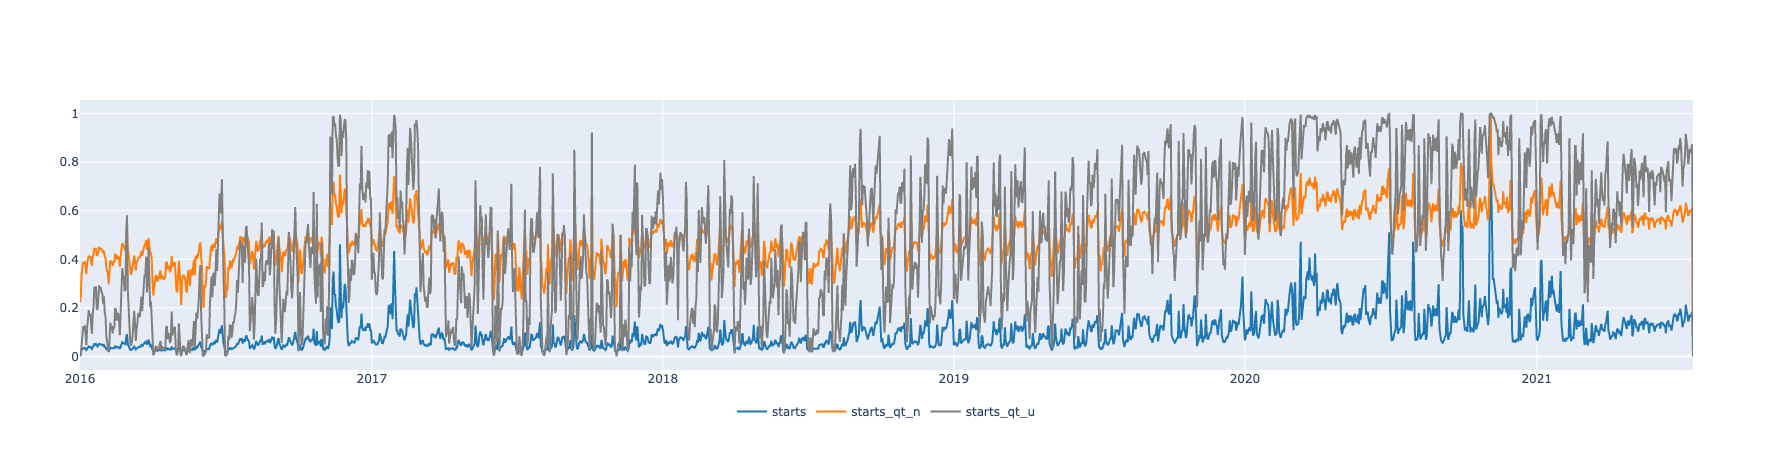

In [577]:
from sklearn.preprocessing import QuantileTransformer

#try two different quantile transformers: uniform distro and normal distro
quantile_u = QuantileTransformer(output_distribution='uniform')
data_trans_qt_u = quantile_u.fit_transform(core_starts_df_grouped[['starts']])

quantile_n = QuantileTransformer(output_distribution='normal')
data_trans_qt_n = quantile_n.fit_transform(core_starts_df_grouped[['starts']])

#add them to training data (only use 1 of the 3 versions of 'starts', not all 3)
core_starts_df_grouped['starts_qt_u'] = data_trans_qt_u
core_starts_df_grouped['starts_qt_n'] = data_trans_qt_n

#see what it looks like
plot_variables(core_starts_df_grouped, ['starts','starts_qt_n', 'starts_qt_u'], one_plot=True, scaled=True)

In [578]:
# df_display_agg = df_display_agg.merge(imps_df, how='left', left_index=True, right_index=True)

In [579]:
df_display_agg = df_display_agg.merge(traffic_df_grouped, how='left', left_index=True,right_index=True)

In [580]:
df_display_agg = df_display_agg.merge(core_starts_df_grouped, how='left', right_index=True, left_index=True)

In [581]:
df_display_agg['spend'].sum()

21704197.870152626

In [582]:
# plot_variables(df_display_agg.reset_index(), [col for col in df_display_agg.columns], one_plot=True, scaled=True)

In [583]:
# get_corr_matrix(df_display_agg, [col for col in df_display_agg.columns], start='2020-01-01', end='2021-07-15')

__try adding dummies__

In [584]:
df_display_agg['weekday'] = df_display_agg.index.day_name()

In [585]:
df_display_agg = pd.concat([df_display_agg, 
               pd.get_dummies(df_display_agg['weekday'], prefix='weekday')], axis=1)

df_display_agg.drop('weekday', axis=1, inplace=True)

In [586]:
# df_display_agg['election_day'] = 0
# df_display_agg.loc['2020-11-04':'2020-11-04', 'election_day'] = 1

In [587]:
X = df_display_agg.drop('all_conversions_vt', axis=1)
y = df_display_agg['all_conversions_vt']

In [589]:
#select vars
X = X[['impressions','clicks','spend','all_conversions_ct','agents','starts_qt_n'] + [col for col in X.columns if 'weekday' in col]]

In [483]:
# X = X[X['date'] <= '2021-07-15']
# y = y[y['date'] <= '2021-07-15']

In [591]:
X = X[:'2021-07-15']
y = y[:'2021-07-15']

In [592]:
# X = sm.add_constant(X)

In [594]:
# ols_test = sm.OLS(y[['all_conversions_vt']], X[['impressions','clicks','spend','all_conversions_ct']]).fit() 
ols_test = sm.OLS(y, X).fit()
ols_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     all_conversions_vt   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     360.3
Date:                Wed, 21 Jul 2021   Prob (F-statistic):          1.44e-233
Time:                        17:16:49   Log-Likelihood:                -3125.8
No. Observations:                 501   AIC:                             6278.
Df Residuals:                     488   BIC:                             6332.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
impressions         4.302e-05   3.38e-06     12.724      0.000    3.64e-05    4.97e-05
clicks                -0.0599      0.009     -6.965      0.000      -0.077      -0.043
spend                 -0.0011      0.000     -2.493      0.013      -0.002      -0.000
all_conversions_ct     9.1280      1.387      6.582      0.000       6.403      11.853
agents              9.497e-06   9.61e-07      9.887      0.000    7.61e-06    1.14e-05
starts_qt_n          287.1589     14.074     20.403      0.000     259.505     314.813
weekday_Friday       -48.8984     21.984     -2.224      0.027     -92.093      -5.704
weekday_Monday       -41.7218     22.051     -1.892      0.059     -85.048       1.605
weekday_Saturday     -38.4863     22.478     -1.712      0.088     -82.653       5.680
weekday_Sunday       -31.3968     22.239     -1.412      0.159     -75.092      12.298
weekday_Thursday     -68.8736     21.918     -3.142      0.002    -111.939     -25.809
weekday_Tuesday      -52.1145     22.425     -2.324      0.021     -96.176      -8.053
weekday_Wednesday    -68.0356     22.774     -2.987      0.003    -112.783     -23.288
==============================================================================
Omnibus:                      116.484   Durbin-Watson:                   0.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              428.267
Skew:                           1.021   Prob(JB):                     1.01e-93
Kurtosis:                       7.043   Cond. No.                     1.86e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.86e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [595]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y
ols_vis['resid'] = ols_vis['y_pred'] - ols_vis['y_actual']

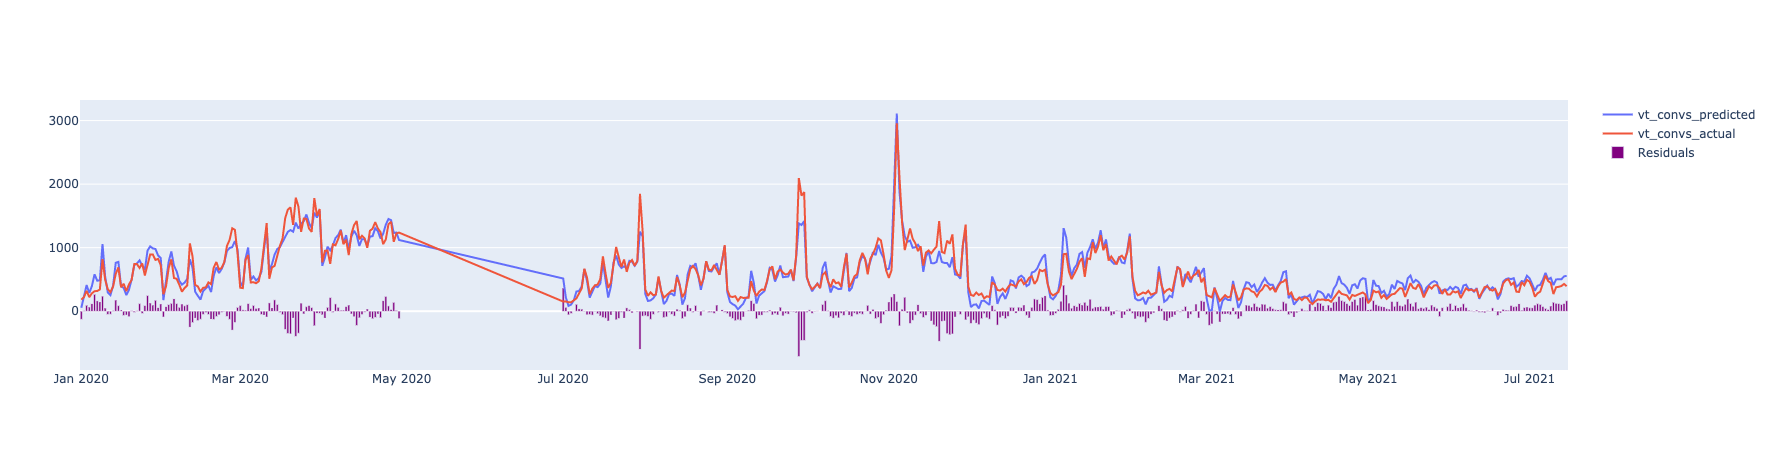

In [596]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='vt_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='vt_convs_actual'))

fig.add_trace(go.Bar(
    x=ols_vis.index,
    y=ols_vis['resid'],
    name='Residuals',
    marker_color='purple'
))

fig.show()

__Try holding out the last few months__

In [597]:
is_s = '2019-01-01'
is_e = '2021-03-31'

oos_s = '2021-04-01'
oos_e = '2021-06-15'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [598]:
def get_predictions(X_train, X_test, y_train, y_test, summary=False, vis=False): 
    # BUILD MODEL
    ols = sm.OLS(y_train, X_train).fit()
    
    if summary:
        print(ols.summary())
    
    # TRAIN
    train_ols_y_pred = ols.predict(X_train)

    train_ols_results = X_train.copy()
    train_ols_results['y_pred'] = train_ols_y_pred
    train_ols_results['y_actual'] = y_train
    train_ols_results['resid'] = train_ols_results['y_pred'] - train_ols_results['y_actual']
    train_ols_results['abs_err'] = abs(train_ols_results['resid'])
    train_ols_results['abs_err_pct'] = train_ols_results['abs_err'] / train_ols_results['y_actual']
    train_ols_results['samp'] = 'in_samp'

    # TEST
    test_ols_y_pred = ols.predict(X_test)

    test_ols_results = X_test.copy()
    test_ols_results['y_pred'] = test_ols_y_pred
    test_ols_results['y_actual'] = y_test
    test_ols_results['resid'] = test_ols_results['y_pred'] - test_ols_results['y_actual']
    test_ols_results['abs_err'] = abs(test_ols_results['resid'])
    test_ols_results['abs_err_pct'] = test_ols_results['abs_err'] / test_ols_results['y_actual']
    test_ols_results['samp'] = 'out_samp'

    # COMBINE
    ols_results = pd.concat([train_ols_results,test_ols_results])
    ols_results.sort_index(inplace=True)
    
    if vis: 
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=ols_results.index, y=ols_results['y_pred'],
                            mode='lines',
                            name='vt_conversions_predicted'))
        fig.add_trace(go.Scatter(x=ols_results.index, y=ols_results['y_actual'],
                            mode='lines',
                            name='vt_conversions_actual'))
        fig.add_trace(go.Bar(
            x=ols_results.index,
            y=ols_results['resid'],
            name='Residuals',
            marker_color='purple'
        ))

#         fig.add_vline(x=oos_s, line_width=1, line_dash="dash", line_color="black")

        fig.show()
    
    return ols, ols_results

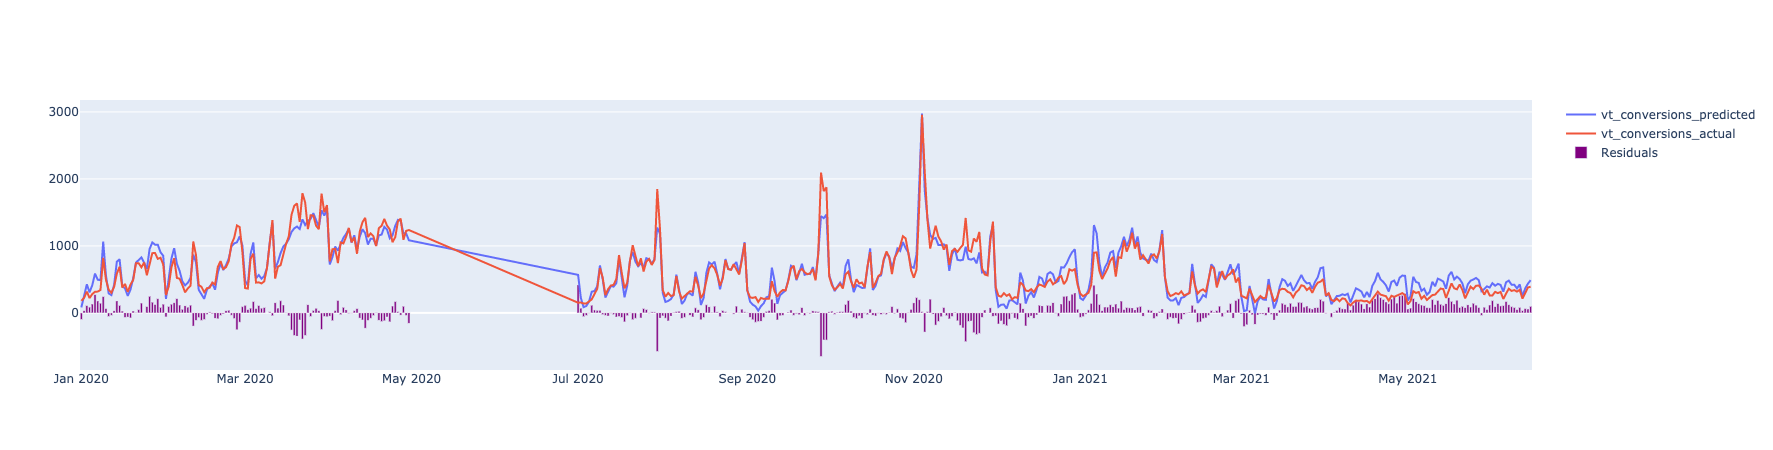

In [599]:
model, results_df = get_predictions(X_train, X_test, y_train, y_test, vis=True)

In [600]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     all_conversions_vt   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     290.7
Date:                Wed, 21 Jul 2021   Prob (F-statistic):          1.13e-183
Time:                        17:17:12   Log-Likelihood:                -2472.6
No. Observations:                 395   AIC:                             4971.
Df Residuals:                     382   BIC:                             5023.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
impressions         3.807e-05   3.62e-06     10.521      0.000     3.1e-05    4.52e-05
clicks                -0.0629      0.009     -6.912      0.000      -0.081      -0.045
spend              -4.451e-05      0.001     -0.088      0.930      -0.001       0.001
all_conversions_ct     7.6798      1.554      4.943      0.000       4.625      10.735
agents               7.35e-06   1.04e-06      7.048      0.000     5.3e-06     9.4e-06
starts_qt_n          312.7796     15.696     19.928      0.000     281.919     343.640
weekday_Friday        19.0386     25.537      0.746      0.456     -31.172      69.249
weekday_Monday        35.2847     25.795      1.368      0.172     -15.434      86.003
weekday_Saturday      31.9162     26.591      1.200      0.231     -20.368      84.200
weekday_Sunday        42.5779     25.988      1.638      0.102      -8.520      93.676
weekday_Thursday       2.9164     25.616      0.114      0.909     -47.450      53.283
weekday_Tuesday       27.7222     26.358      1.052      0.294     -24.103      79.548
weekday_Wednesday     11.9747     26.747      0.448      0.655     -40.615      64.564
==============================================================================
Omnibus:                       71.086   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.000
Skew:                           0.789   Prob(JB):                     1.54e-51
Kurtosis:                       6.425   Cond. No.                     2.04e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### __Get MAPE__

In [601]:
def get_mapes(ols_results):
    is_mape = ols_results[ols_results['samp'] == 'in_samp']['abs_err_pct'].mean()
    oos_mape = ols_results[ols_results['samp'] == 'out_samp']['abs_err_pct'].mean()
    overall_mape = ols_results['abs_err_pct'].mean()

    print(f'Overall MAPE: {overall_mape:.2%}')
    print(f'In Sample MAPE: {is_mape:.2%}')
    print(f'Out of Sample MAPE: {oos_mape:.2%}')
    
    return overall_mape, is_mape, oos_mape

In [602]:
get_mapes(results_df)

Overall MAPE: 22.71%
In Sample MAPE: 17.87%
Out of Sample MAPE: 47.86%


(0.2270857047838906, 0.17868911686538158, 0.4786206025182465)

__The model performs well on in-sample data but not out of sample data. Let's try randomizing the training set and the test set and see how the model performs when it is given some data from 2021 as well.__

Train test split is an sklearn object that takes the X (indep vars) and y (dep var) and randomly splits them into training and testing sets.

In [603]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

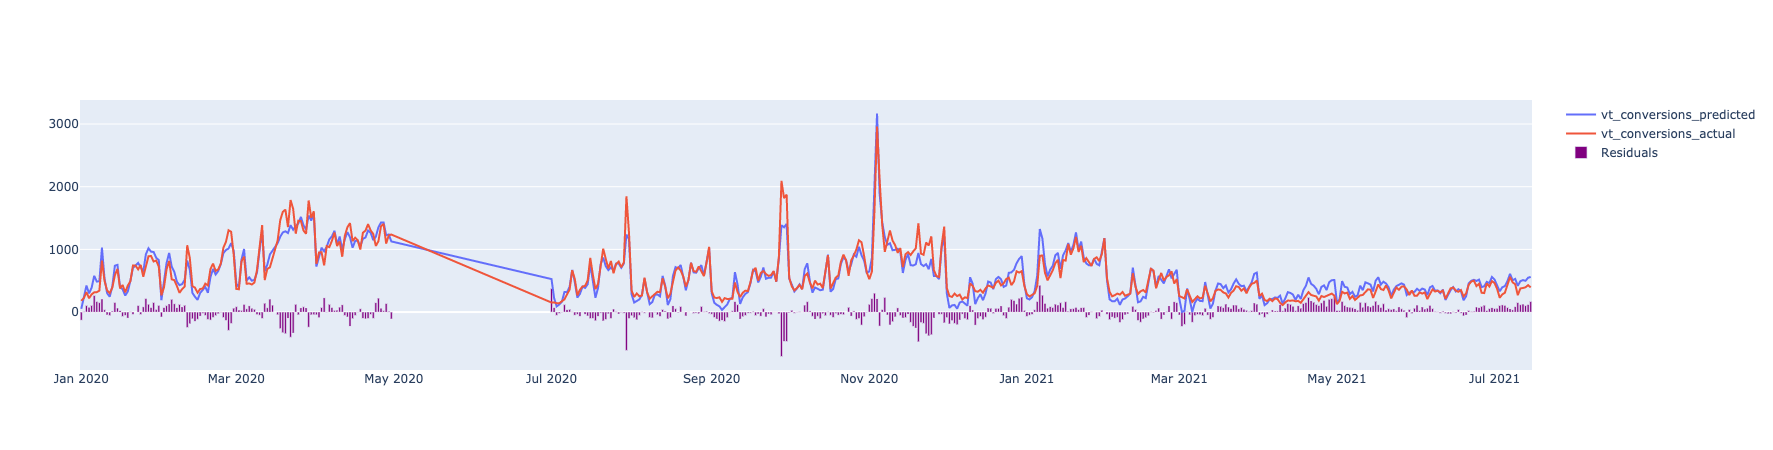

In [604]:
ols_model, ols_results = get_predictions(X_train, X_test, y_train, y_test, vis=True)

In [605]:
get_mapes(ols_results)

Overall MAPE: 20.43%
In Sample MAPE: 20.88%
Out of Sample MAPE: 19.53%


(0.20431634384086478, 0.2087799600760528, 0.19530844360720226)

In [606]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     all_conversions_vt   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     232.9
Date:                Wed, 21 Jul 2021   Prob (F-statistic):          1.07e-150
Time:                        17:17:33   Log-Likelihood:                -2094.5
No. Observations:                 335   AIC:                             4215.
Df Residuals:                     322   BIC:                             4265.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
impressions         4.423e-05   4.27e-06     10.348      0.000    3.58e-05    5.26e-05
clicks                -0.0607      0.011     -5.625      0.000      -0.082      -0.039
spend                 -0.0013      0.001     -2.436      0.015      -0.002      -0.000
all_conversions_ct     7.6606      1.858      4.124      0.000       4.006      11.315
agents              9.972e-06   1.18e-06      8.454      0.000    7.65e-06    1.23e-05
starts_qt_n          294.3235     17.773     16.560      0.000     259.357     329.290
weekday_Friday       -50.4594     27.077     -1.864      0.063    -103.729       2.810
weekday_Monday       -45.1377     26.831     -1.682      0.093     -97.923       7.648
weekday_Saturday     -31.9623     28.319     -1.129      0.260     -87.676      23.752
weekday_Sunday       -43.3501     28.398     -1.527      0.128     -99.219      12.519
weekday_Thursday     -71.7115     26.574     -2.699      0.007    -123.992     -19.431
weekday_Tuesday      -59.6638     26.240     -2.274      0.024    -111.287      -8.040
weekday_Wednesday    -71.4776     28.212     -2.534      0.012    -126.980     -15.975
==============================================================================
Omnibus:                      102.806   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              412.180
Skew:                           1.272   Prob(JB):                     3.13e-90
Kurtosis:                       7.802   Cond. No.                     1.79e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.79e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [500]:
X = df_display_agg.drop('all_conversions_vt', axis=1)
y = df_display_agg['all_conversions_vt']

In [501]:
X = X[:'2021-07-15']
y = y[:'2021-07-15']

In [607]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

In [608]:
def run_xgb(X_train, X_test, y_train, y_test, feature_importances=False, vis=False, mapes=False, hlines=None):
    # Random Search Parameters
    params_random_search = {
        'learning_rate': np.arange(0.01, 1.01, 0.01),
        'n_estimators': [200],
        'max_depth': range(2, 12),
        'subsample': np.arange(0.02, 1.02, 0.02)
    }


    xg_random_reg = xgb.XGBRegressor(objective= "reg:squarederror")

    randomized_mse = RandomizedSearchCV(param_distributions=params_random_search, estimator=xg_random_reg,
                                        scoring="neg_mean_squared_error", n_iter=5, cv=4, verbose=1, iid=True)
    randomized_mse.fit(X_train, y_train)
    
    if feature_importances:
        for i in range(0, len(X_train.columns)):
            print(f'Feature importance: {X_train.columns[i]} = {randomized_mse.best_estimator_.feature_importances_[i]:>.2%}')
    
    # TRAIN
    train_ols_y_pred = randomized_mse.predict(X_train)

    train_ols_results = X_train.copy()
    train_ols_results['y_pred'] = train_ols_y_pred
    train_ols_results['y_actual'] = y_train
    train_ols_results['resid'] = train_ols_results['y_pred'] - train_ols_results['y_actual']
    train_ols_results['abs_err'] = abs(train_ols_results['resid'])
    train_ols_results['abs_err_pct'] = train_ols_results['abs_err'] / train_ols_results['y_actual']
    train_ols_results['samp'] = 'in_samp'

    # TEST
    test_ols_y_pred = randomized_mse.predict(X_test)

    test_ols_results = X_test.copy()
    test_ols_results['y_pred'] = test_ols_y_pred
    test_ols_results['y_actual'] = y_test
    test_ols_results['resid'] = test_ols_results['y_pred'] - test_ols_results['y_actual']
    test_ols_results['abs_err'] = abs(test_ols_results['resid'])
    test_ols_results['abs_err_pct'] = test_ols_results['abs_err'] / test_ols_results['y_actual']
    test_ols_results['samp'] = 'out_samp'

    # COMBINE
    ols_results = pd.concat([train_ols_results,test_ols_results])
    ols_results.sort_index(inplace=True)
    
    if mapes: 
        get_mapes(ols_results)
    
    if vis: 
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=ols_results.index, y=ols_results['y_pred'],
                            mode='lines',
                            name='vt_conversions_predicted'))
        fig.add_trace(go.Scatter(x=ols_results.index, y=ols_results['y_actual'],
                            mode='lines',
                            name='vt_conversions_actual'))
        fig.add_trace(go.Bar(
            x=ols_results.index,
            y=ols_results['resid'],
            name='Residuals',
            marker_color='purple'
        ))

        if hlines: 
            for hline in hlines: 

                fig.add_vline(x=hline, line_width=1, line_dash="dash", line_color="black")

        fig.show()
        
    return randomized_mse, ols_results

In [609]:
# # Random Search Parameters
# params_random_search = {
#     'learning_rate': np.arange(0.01, 1.01, 0.01),
#     'n_estimators': [200],
#     'max_depth': range(2, 12),
#     'subsample': np.arange(0.02, 1.02, 0.02)
# }


# xg_random_reg = xgb.XGBRegressor(objective= "reg:squarederror")

# randomized_mse = RandomizedSearchCV(param_distributions=params_random_search, estimator=xg_random_reg,
#                                     scoring="neg_mean_squared_error", n_iter=5, cv=4, verbose=1, iid=True)
# randomized_mse.fit(X_train, y_train)

# print("Randomize Search Cross Validation")
# print("Best parameters found: ", randomized_mse.best_params_)
# print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

In [610]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

In [396]:
X_train = pd.concat([X['2020-01-01':'2020-12-31'], X['2021-04-01':'2021-07-15']])

,impressions,clicks,spend,all_conversions_ct,agents,starts,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
date,,,,,,,,,,,,,
2020-01-01,30301912.0,120870.0,74904.401884,246.0,11265833.0,5111.0,0,0,0,0,0,0,1
2020-01-02,25906112.0,198962.0,75241.844142,375.0,13093203.0,6233.0,0,0,0,0,1,0,0
2020-01-03,31191437.0,260335.0,117587.795767,511.0,19037928.0,8598.0,1,0,0,0,0,0,0
2020-01-04,33248865.0,265753.0,113206.921459,562.0,12703427.0,6997.0,0,0,1,0,0,0,0
2020-01-05,33674365.0,254272.0,109474.915445,581.0,13340911.0,8071.0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-11,23477484.0,128293.0,117003.602458,234.0,14441197.0,12796.0,0,0,0,1,0,0,0
2021-07-12,22560962.0,119688.0,118237.332861,308.0,12966961.0,13160.0,0,1,0,0,0,0,0
2021-07-13,23062196.0,121556.0,132507.191480,201.0,12228528.0,12606.0,0,0,0,0,0,1,0


In [612]:
# is_s = '2019-01-01'
# is_e = '2020-12-31'

# oos_s = '2021-01-01'
# oos_e = '2021-07-15'

# X_train = X.loc[is_s:is_e]
# X_test = X.loc[oos_s:oos_e]

# y_train = y.loc[is_s:is_e]
# y_test = y.loc[oos_s:oos_e]

X_train = pd.concat([X['2020-01-01':'2020-12-31'], X['2021-04-01':'2021-07-15']])
X_test = X.loc['2021-01-01':'2021-03-31']

y_train = pd.concat([y['2020-01-01':'2020-12-31'], y['2021-04-01':'2021-07-15']])
y_test = y.loc['2021-01-01':'2021-03-31']



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Feature importance: impressions = 5.09%
Feature importance: clicks = 2.49%
Feature importance: spend = 1.97%
Feature importance: all_conversions_ct = 2.95%
Feature importance: agents = 5.36%
Feature importance: starts_qt_n = 71.25%
Feature importance: weekday_Friday = 1.21%
Feature importance: weekday_Monday = 2.29%
Feature importance: weekday_Saturday = 2.24%
Feature importance: weekday_Sunday = 0.98%
Feature importance: weekday_Thursday = 1.18%
Feature importance: weekday_Tuesday = 1.67%
Feature importance: weekday_Wednesday = 1.32%
Overall MAPE: 3.62%
In Sample MAPE: 0.30%
Out of Sample MAPE: 18.75%


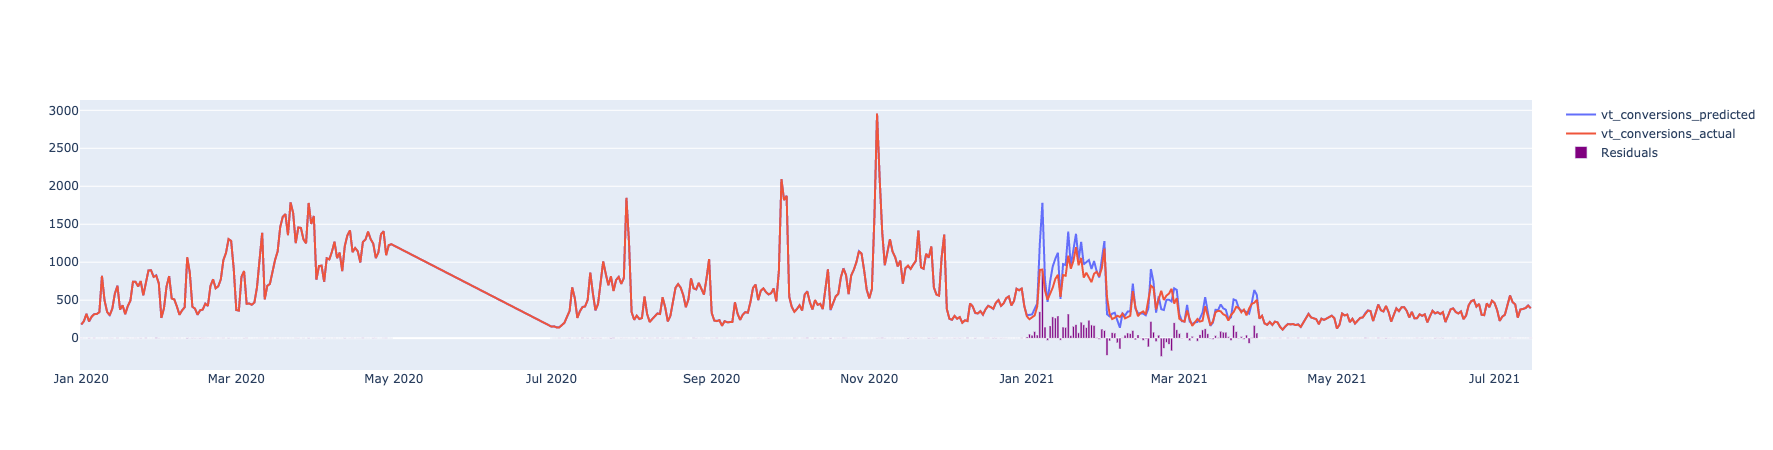

In [613]:
test_model, test_results = run_xgb(X_train, X_test, y_train, y_test, feature_importances=True, vis=True, mapes=True)

In [250]:
#instantiate results dict
results = {}

for i in range(0, 20):
    #get data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)
    
    #build model
    xgb_model, modeled_df = run_xgb(X_train, X_test, y_train, y_test)
    
    results['iteration_' + str(i)] = [xgb_model]
    results['iteration_' + str(i)].append(modeled_df)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.2s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.7s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.2s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.5s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



In [251]:
#instantiate empty lists for dataframe
lists = [[] for _ in range(0, len(X_train.columns))]    

overall_mapes_ls = []
is_mapes_ls = []
oos_mapes_ls = []

for i in range(0, len(results.values())):
    #get mapes and write to list
    overall_mape, is_mape, oos_mape = get_mapes(results['iteration_'+str(i)][1])
    
    overall_mapes_ls.append(overall_mape)
    is_mapes_ls.append(is_mape)
    oos_mapes_ls.append(oos_mape)
    
    for col in range(0, len(X_train.columns)):
        #get feature importances for each col 
        lists[col].append(results['iteration_'+str(i)][0].best_estimator_.feature_importances_[col])

Overall MAPE: 5.49%
In Sample MAPE: 0.00%
Out of Sample MAPE: 16.58%
Overall MAPE: 5.24%
In Sample MAPE: 1.66%
Out of Sample MAPE: 12.46%
Overall MAPE: 5.22%
In Sample MAPE: 0.78%
Out of Sample MAPE: 14.19%
Overall MAPE: 6.14%
In Sample MAPE: 0.00%
Out of Sample MAPE: 18.53%
Overall MAPE: 5.96%
In Sample MAPE: 1.51%
Out of Sample MAPE: 14.95%
Overall MAPE: 4.91%
In Sample MAPE: 0.00%
Out of Sample MAPE: 14.81%
Overall MAPE: 4.42%
In Sample MAPE: 0.00%
Out of Sample MAPE: 13.35%
Overall MAPE: 6.39%
In Sample MAPE: 3.07%
Out of Sample MAPE: 13.10%
Overall MAPE: 7.01%
In Sample MAPE: 3.23%
Out of Sample MAPE: 14.63%
Overall MAPE: 5.21%
In Sample MAPE: 0.00%
Out of Sample MAPE: 15.71%
Overall MAPE: 4.79%
In Sample MAPE: 0.07%
Out of Sample MAPE: 14.34%
Overall MAPE: 5.49%
In Sample MAPE: 1.66%
Out of Sample MAPE: 13.20%
Overall MAPE: 5.81%
In Sample MAPE: 1.05%
Out of Sample MAPE: 15.40%
Overall MAPE: 5.11%
In Sample MAPE: 1.06%
Out of Sample MAPE: 13.28%
Overall MAPE: 8.61%
In Sample MAPE

In [252]:
lists_reshaped = [list(x) for x in zip(*lists)]

In [253]:
xgb_results_df = pd.DataFrame(index=results.keys(), columns=[col+'_importance' for col in X_train.columns], 
                             data=lists_reshaped)

xgb_results_df['Overall MAPE'] = overall_mapes_ls
xgb_results_df['In-Sample MAPE'] = is_mapes_ls
xgb_results_df['Out-of-Sample MAPE'] = oos_mapes_ls

In [254]:
xgb_results_df.describe()

,clicks_Business As Usual_importance,clicks_Content/Audience Development_importance,clicks_Engagement_importance,clicks_Gifting_importance,clicks_One Day Sale_importance,clicks_Sale_importance,clicks_Testing_importance,clicks_X-UNKNOWN-X_importance,spend_Business As Usual_importance,spend_Content/Audience Development_importance,spend_Engagement_importance,spend_Gifting_importance,spend_One Day Sale_importance,spend_Sale_importance,spend_Testing_importance,spend_X-UNKNOWN-X_importance,impressions_Business As Usual_importance,impressions_Content/Audience Development_importance,impressions_Engagement_importance,impressions_Gifting_importance,impressions_One Day Sale_importance,impressions_Sale_importance,impressions_Testing_importance,impressions_X-UNKNOWN-X_importance,all_conversions_ct_Business As Usual_importance,all_conversions_ct_Content/Audience Development_importance,all_conversions_ct_Engagement_importance,all_conversions_ct_Gifting_importance,all_conversions_ct_One Day Sale_importance,all_conversions_ct_Sale_importance,all_conversions_ct_Testing_importance,all_conversions_ct_X-UNKNOWN-X_importance,agents_importance,starts_importance,weekday_Friday_importance,weekday_Monday_importance,weekday_Saturday_importance,weekday_Sunday_importance,weekday_Thursday_importance,weekday_Tuesday_importance,weekday_Wednesday_importance,Overall MAPE,In-Sample MAPE,Out-of-Sample MAPE
count,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,2.000000e+01,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,2.000000e+01,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000
mean,0.003805,0.020025,0.0,0.023180,0.013281,0.006366,0.045396,0.004228,0.007555,0.0,0.0,0.005929,0.012355,0.007508,0.025685,0.0,0.007251,7.144501e-03,0.0,0.006881,0.017415,0.121699,0.047509,0.005157,0.005972,0.0,0.0,5.912959e-04,0.010573,0.020506,0.011473,0.0,0.025940,0.498310,0.005284,0.003503,0.009149,0.005285,0.003555,0.004823,0.006664,0.055977,1.023773e-02,0.148283
std,0.001840,0.046752,0.0,0.015641,0.008610,0.003617,0.028317,0.004911,0.002769,0.0,0.0,0.004547,0.011661,0.003461,0.037187,0.0,0.002636,1.789989e-02,0.0,0.005527,0.023139,0.090578,0.083122,0.006731,0.002709,0.0,0.0,2.361839e-03,0.009017,0.013672,0.018996,0.0,0.008323,0.124679,0.004862,0.002578,0.004740,0.003410,0.002922,0.003447,0.007153,0.009310,1.561627e-02,0.014904
min,0.001390,0.000000,0.0,0.002565,0.001541,0.001754,0.007197,0.001013,0.003533,0.0,0.0,0.000425,0.000032,0.001947,0.001553,0.0,0.002704,0.000000e+00,0.0,0.001374,0.000000,0.012786,0.000176,0.000000,0.001088,0.0,0.0,0.000000e+00,0.000403,0.003938,0.000000,0.0,0.014930,0.258645,0.000275,0.000130,0.002890,0.001029,0.000359,0.001045,0.000201,0.044228,8.888528e-07,0.124574
25%,0.002471,0.000000,0.0,0.009382,0.006574,0.003245,0.023882,0.002018,0.005362,0.0,0.0,0.001486,0.002222,0.005143,0.007856,0.0,0.004940,0.000000e+00,0.0,0.003421,0.001789,0.046367,0.010459,0.000521,0.003557,0.0,0.0,0.000000e+00,0.005512,0.011782,0.002119,0.0,0.020371,0.428866,0.001074,0.001618,0.006165,0.003184,0.001548,0.002220,0.002205,0.050651,1.005083e-06,0.136637
50%,0.003327,0.000160,0.0,0.019924,0.010666,0.006017,0.036286,0.002973,0.007614,0.0,0.0,0.005390,0.008589,0.006677,0.013484,0.0,0.007244,1.244592e-07,0.0,0.004499,0.005312,0.101442,0.016781,0.002315,0.006145,0.0,0.0,0.000000e+00,0.007060,0.015277,0.005529,0.0,0.023199,0.469121,0.004199,0.003025,0.008410,0.004616,0.002921,0.003472,0.005049,0.053762,1.916181e-03,0.147304
75%,0.004993,0.018616,0.0,0.033968,0.018539,0.008957,0.069644,0.004327,0.008967,0.0,0.0,0.009286,0.021427,0.009744,0.019942,0.0,0.009224,2.266571e-03,0.0,0.009182,0.028323,0.163618,0.059592,0.007185,0.007687,0.0,0.0,5.262432e-07,0.013677,0.024367,0.009566,0.0,0.033364,0.601482,0.007003,0.005238,0.011304,0.006287,0.005088,0.00723

In [151]:
# xgb_results_df_v1 = xgb_results_df.copy()
'''
this is 100 iterations with constant included - the constant does nothing so can be removed 
'''
xgb_results_df_v1.describe()

,const_importance,impressions_importance,clicks_importance,all_conversions_ct_importance,agents_importance,starts_importance,IS_MAPE,OOS_MAPE,Overall_MAPE
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,0.0,0.062675,0.027524,0.075051,0.062514,0.772235,2.604501e-02,0.173942,0.075049
std,0.0,0.039989,0.023079,0.058026,0.034355,0.131054,3.878183e-02,0.023424,0.026935
min,0.0,0.015038,0.005900,0.008597,0.021111,0.323978,9.220163e-07,0.131117,0.047715
25%,0.0,0.030498,0.013403,0.031912,0.038902,0.690996,8.342184e-05,0.158692,0.058045
50%,0.0,0.047522,0.020898,0.053057,0.051137,0.806778,6.938882e-03,0.170644,0.065766
75%,0.0,0.088043,0.035184,0.105843,0.077526,0.876161,4.030332e-02,0.182254,0.084310
max,0.0,0.168737,0.176681,0.268511,0.183398,0.931797,1.813173e-01,0.278673,0.213575


In [161]:
# xgb_results_df_v2 = xgb_results_df.copy()
'''
this is 20 iterations with constant removed
'''
xgb_results_df_v2.describe()

,impressions_importance,clicks_importance,all_conversions_ct_importance,agents_importance,starts_importance,IS_MAPE,OOS_MAPE,Overall_MAPE
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.058336,0.029942,0.092853,0.064704,0.754165,0.027438,0.165971,0.073339
std,0.029734,0.022032,0.077262,0.042995,0.139932,0.034032,0.014532,0.022859
min,0.026026,0.008976,0.020566,0.018837,0.399913,0.000001,0.139696,0.048523
25%,0.037508,0.014494,0.044550,0.042917,0.694819,0.000589,0.157659,0.055082
50%,0.048229,0.024760,0.063290,0.052837,0.810484,0.006985,0.165847,0.064796
75%,0.070827,0.032163,0.109676,0.073304,0.859951,0.048957,0.174528,0.085599
max,0.120025,0.083886,0.290827,0.222722,0.921912,0.099984,0.194483,0.124451


In [221]:
# xgb_results_df_v3 = xgb_results_df.copy()
'''
this is 20 iterations with impressions split by marketing_initiative. performance is slightly better but meh not really
'''
xgb_results_df_v3.describe()

,clicks_importance,spend_importance,all_conversions_ct_importance,impressions_Business As Usual_importance,impressions_Content/Audience Development_importance,impressions_Engagement_importance,impressions_Gifting_importance,impressions_One Day Sale_importance,impressions_Sale_importance,impressions_Testing_importance,impressions_X-UNKNOWN-X_importance,agents_importance,starts_importance,Overall MAPE,In-Sample MAPE,Out-of-Sample MAPE
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000
mean,0.015942,0.014272,0.030211,0.014396,8.621956e-03,0.0,0.021330,0.029415,0.095304,0.072352,0.011895,0.043683,0.642579,0.066723,2.207276e-02,0.156830
std,0.015123,0.010241,0.028710,0.008217,1.330626e-02,0.0,0.015202,0.024907,0.059058,0.034393,0.023028,0.025189,0.143244,0.025082,3.714843e-02,0.022462
min,0.004138,0.004078,0.008608,0.006186,0.000000e+00,0.0,0.002424,0.006218,0.025581,0.031119,0.000000,0.017864,0.356463,0.040757,8.357318e-07,0.122132
25%,0.005550,0.006080,0.012509,0.008633,4.775267e-07,0.0,0.011995,0.010720,0.052170,0.051712,0.000401,0.026442,0.570778,0.050773,1.346007e-06,0.142113
50%,0.008475,0.013063,0.016152,0.011890,3.499612e-03,0.0,0.016957,0.018171,0.073465,0.065259,0.003411,0.033909,0.653561,0.056772,1.805742e-04,0.154466
75%,0.019775,0.016987,0.035784,0.017821,1.228282e-02,0.0,0.028406,0.040250,0.133059,0.090437,0.012349,0.051042,0.769718,0.074435,3.468446e-02,0.168846
max,0.060784,0.045924,0.099207,0.038055,5.736263e-02,0.0,0.053527,0.083250,0.214299,0.178906,0.091080,0.108653,0.821676,0.128193,1.067110e-01,0.215824


## Try Random Forest

__two methods: continuous held-out testing data and randomized train and test__

In [516]:
is_s = '2019-01-01'
is_e = '2021-03-31'

oos_s = '2021-04-01'
oos_e = '2021-06-15'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [518]:
X_train = pd.concat([X['2020-01-01':'2020-12-31'], X['2021-04-01':'2021-07-15']])
X_test = X.loc['2021-01-01':'2021-03-31']

y_train = pd.concat([y['2020-01-01':'2020-12-31'], y['2021-04-01':'2021-07-15']])
y_test = y.loc['2021-01-01':'2021-03-31']

In [526]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)

In [509]:
from sklearn.ensemble import RandomForestRegressor

In [512]:
def run_randfor(X_train, X_test, y_train, y_test, feature_importances=False, vis=False, mapes=False, hlines=None):
    # Random Search Parameters
#     params_random_search = {
#         'learning_rate': np.arange(0.01, 1.01, 0.01),
#         'n_estimators': [200],
#         'max_depth': range(2, 12),
#         'subsample': np.arange(0.02, 1.02, 0.02)
#     }


    rf_reg = RandomForestRegressor()

#     randomized_mse = RandomizedSearchCV(param_distributions=params_random_search, estimator=xg_random_reg,
#                                         scoring="neg_mean_squared_error", n_iter=5, cv=4, verbose=1, iid=True)
    rf_reg.fit(X_train, y_train)
    
    if feature_importances:
        for i in range(0, len(X_train.columns)):
            print(f'Feature importance: {X_train.columns[i]} = {rf_reg.feature_importances_[i]:>.2%}')
    
    # TRAIN
    train_ols_y_pred = rf_reg.predict(X_train)

    train_ols_results = X_train.copy()
    train_ols_results['y_pred'] = train_ols_y_pred
    train_ols_results['y_actual'] = y_train
    train_ols_results['resid'] = train_ols_results['y_pred'] - train_ols_results['y_actual']
    train_ols_results['abs_err'] = abs(train_ols_results['resid'])
    train_ols_results['abs_err_pct'] = train_ols_results['abs_err'] / train_ols_results['y_actual']
    train_ols_results['samp'] = 'in_samp'

    # TEST
    test_ols_y_pred = rf_reg.predict(X_test)

    test_ols_results = X_test.copy()
    test_ols_results['y_pred'] = test_ols_y_pred
    test_ols_results['y_actual'] = y_test
    test_ols_results['resid'] = test_ols_results['y_pred'] - test_ols_results['y_actual']
    test_ols_results['abs_err'] = abs(test_ols_results['resid'])
    test_ols_results['abs_err_pct'] = test_ols_results['abs_err'] / test_ols_results['y_actual']
    test_ols_results['samp'] = 'out_samp'

    # COMBINE
    ols_results = pd.concat([train_ols_results,test_ols_results])
    ols_results.sort_index(inplace=True)
    
    if mapes: 
        get_mapes(ols_results)
    
    if vis: 
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=ols_results.index, y=ols_results['y_pred'],
                            mode='lines',
                            name='vt_conversions_predicted'))
        fig.add_trace(go.Scatter(x=ols_results.index, y=ols_results['y_actual'],
                            mode='lines',
                            name='vt_conversions_actual'))
        fig.add_trace(go.Bar(
            x=ols_results.index,
            y=ols_results['resid'],
            name='Residuals',
            marker_color='purple'
        ))

        if hlines: 
            for hline in hlines: 

                fig.add_vline(x=hline, line_width=1, line_dash="dash", line_color="black")

        fig.show()
        
    return rf_reg, ols_results

Feature importance: impressions = 5.02%
Feature importance: clicks = 1.16%
Feature importance: spend = 1.70%
Feature importance: all_conversions_ct = 2.01%
Feature importance: agents = 2.78%
Feature importance: starts = 86.51%
Feature importance: weekday_Friday = 0.08%
Feature importance: weekday_Monday = 0.16%
Feature importance: weekday_Saturday = 0.09%
Feature importance: weekday_Sunday = 0.11%
Feature importance: weekday_Thursday = 0.12%
Feature importance: weekday_Tuesday = 0.11%
Feature importance: weekday_Wednesday = 0.15%
Overall MAPE: 9.38%
In Sample MAPE: 6.12%
Out of Sample MAPE: 15.97%


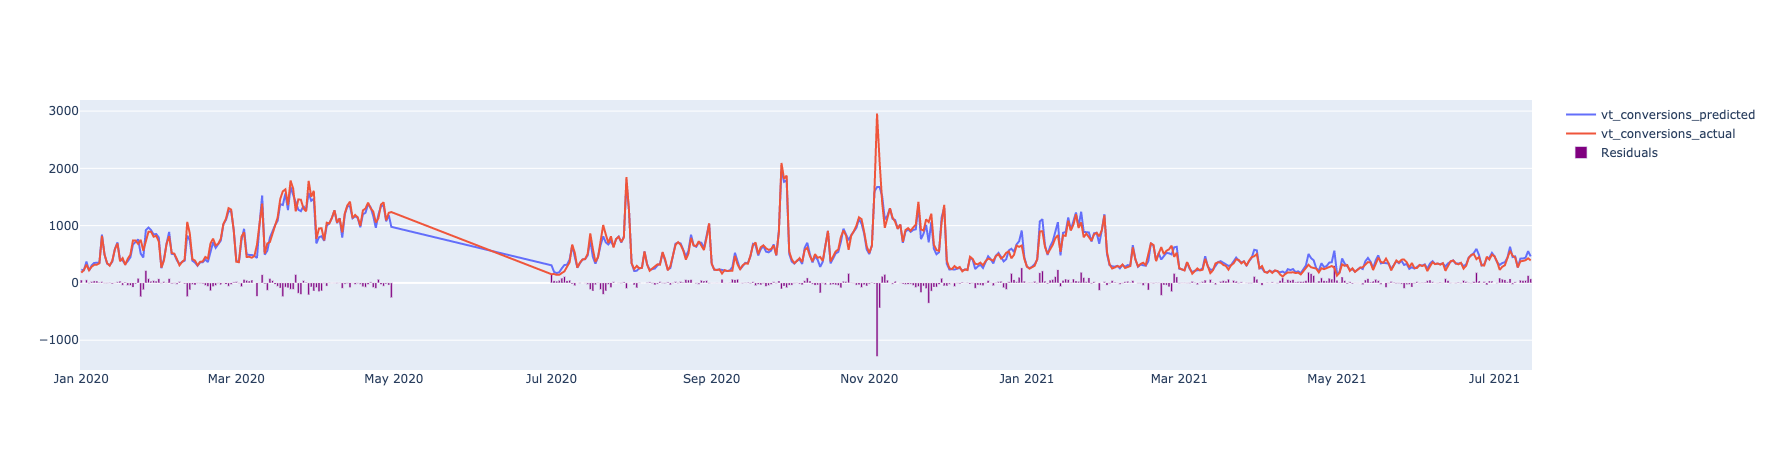

In [527]:
test_model, test_results = run_randfor(X_train, X_test, y_train, y_test, feature_importances=True, vis=True, mapes=True)

In [250]:
#instantiate results dict
results = {}

for i in range(0, 20):
    #get data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=None)
    
    #build model
    xgb_model, modeled_df = run_xgb(X_train, X_test, y_train, y_test)
    
    results['iteration_' + str(i)] = [xgb_model]
    results['iteration_' + str(i)].append(modeled_df)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    6.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    8.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.2s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.7s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.2s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.1s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.5s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.9s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    4.0s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.4s finished
/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning:

The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.



In [251]:
#instantiate empty lists for dataframe
lists = [[] for _ in range(0, len(X_train.columns))]    

overall_mapes_ls = []
is_mapes_ls = []
oos_mapes_ls = []

for i in range(0, len(results.values())):
    #get mapes and write to list
    overall_mape, is_mape, oos_mape = get_mapes(results['iteration_'+str(i)][1])
    
    overall_mapes_ls.append(overall_mape)
    is_mapes_ls.append(is_mape)
    oos_mapes_ls.append(oos_mape)
    
    for col in range(0, len(X_train.columns)):
        #get feature importances for each col 
        lists[col].append(results['iteration_'+str(i)][0].best_estimator_.feature_importances_[col])

Overall MAPE: 5.49%
In Sample MAPE: 0.00%
Out of Sample MAPE: 16.58%
Overall MAPE: 5.24%
In Sample MAPE: 1.66%
Out of Sample MAPE: 12.46%
Overall MAPE: 5.22%
In Sample MAPE: 0.78%
Out of Sample MAPE: 14.19%
Overall MAPE: 6.14%
In Sample MAPE: 0.00%
Out of Sample MAPE: 18.53%
Overall MAPE: 5.96%
In Sample MAPE: 1.51%
Out of Sample MAPE: 14.95%
Overall MAPE: 4.91%
In Sample MAPE: 0.00%
Out of Sample MAPE: 14.81%
Overall MAPE: 4.42%
In Sample MAPE: 0.00%
Out of Sample MAPE: 13.35%
Overall MAPE: 6.39%
In Sample MAPE: 3.07%
Out of Sample MAPE: 13.10%
Overall MAPE: 7.01%
In Sample MAPE: 3.23%
Out of Sample MAPE: 14.63%
Overall MAPE: 5.21%
In Sample MAPE: 0.00%
Out of Sample MAPE: 15.71%
Overall MAPE: 4.79%
In Sample MAPE: 0.07%
Out of Sample MAPE: 14.34%
Overall MAPE: 5.49%
In Sample MAPE: 1.66%
Out of Sample MAPE: 13.20%
Overall MAPE: 5.81%
In Sample MAPE: 1.05%
Out of Sample MAPE: 15.40%
Overall MAPE: 5.11%
In Sample MAPE: 1.06%
Out of Sample MAPE: 13.28%
Overall MAPE: 8.61%
In Sample MAPE

In [252]:
lists_reshaped = [list(x) for x in zip(*lists)]

In [253]:
xgb_results_df = pd.DataFrame(index=results.keys(), columns=[col+'_importance' for col in X_train.columns], 
                             data=lists_reshaped)

xgb_results_df['Overall MAPE'] = overall_mapes_ls
xgb_results_df['In-Sample MAPE'] = is_mapes_ls
xgb_results_df['Out-of-Sample MAPE'] = oos_mapes_ls

In [254]:
xgb_results_df.describe()

,clicks_Business As Usual_importance,clicks_Content/Audience Development_importance,clicks_Engagement_importance,clicks_Gifting_importance,clicks_One Day Sale_importance,clicks_Sale_importance,clicks_Testing_importance,clicks_X-UNKNOWN-X_importance,spend_Business As Usual_importance,spend_Content/Audience Development_importance,spend_Engagement_importance,spend_Gifting_importance,spend_One Day Sale_importance,spend_Sale_importance,spend_Testing_importance,spend_X-UNKNOWN-X_importance,impressions_Business As Usual_importance,impressions_Content/Audience Development_importance,impressions_Engagement_importance,impressions_Gifting_importance,impressions_One Day Sale_importance,impressions_Sale_importance,impressions_Testing_importance,impressions_X-UNKNOWN-X_importance,all_conversions_ct_Business As Usual_importance,all_conversions_ct_Content/Audience Development_importance,all_conversions_ct_Engagement_importance,all_conversions_ct_Gifting_importance,all_conversions_ct_One Day Sale_importance,all_conversions_ct_Sale_importance,all_conversions_ct_Testing_importance,all_conversions_ct_X-UNKNOWN-X_importance,agents_importance,starts_importance,weekday_Friday_importance,weekday_Monday_importance,weekday_Saturday_importance,weekday_Sunday_importance,weekday_Thursday_importance,weekday_Tuesday_importance,weekday_Wednesday_importance,Overall MAPE,In-Sample MAPE,Out-of-Sample MAPE
count,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,20.000000,20.000000,20.000000,20.000000,20.0,20.000000,2.000000e+01,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,2.000000e+01,20.000000,20.000000,20.000000,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000
mean,0.003805,0.020025,0.0,0.023180,0.013281,0.006366,0.045396,0.004228,0.007555,0.0,0.0,0.005929,0.012355,0.007508,0.025685,0.0,0.007251,7.144501e-03,0.0,0.006881,0.017415,0.121699,0.047509,0.005157,0.005972,0.0,0.0,5.912959e-04,0.010573,0.020506,0.011473,0.0,0.025940,0.498310,0.005284,0.003503,0.009149,0.005285,0.003555,0.004823,0.006664,0.055977,1.023773e-02,0.148283
std,0.001840,0.046752,0.0,0.015641,0.008610,0.003617,0.028317,0.004911,0.002769,0.0,0.0,0.004547,0.011661,0.003461,0.037187,0.0,0.002636,1.789989e-02,0.0,0.005527,0.023139,0.090578,0.083122,0.006731,0.002709,0.0,0.0,2.361839e-03,0.009017,0.013672,0.018996,0.0,0.008323,0.124679,0.004862,0.002578,0.004740,0.003410,0.002922,0.003447,0.007153,0.009310,1.561627e-02,0.014904
min,0.001390,0.000000,0.0,0.002565,0.001541,0.001754,0.007197,0.001013,0.003533,0.0,0.0,0.000425,0.000032,0.001947,0.001553,0.0,0.002704,0.000000e+00,0.0,0.001374,0.000000,0.012786,0.000176,0.000000,0.001088,0.0,0.0,0.000000e+00,0.000403,0.003938,0.000000,0.0,0.014930,0.258645,0.000275,0.000130,0.002890,0.001029,0.000359,0.001045,0.000201,0.044228,8.888528e-07,0.124574
25%,0.002471,0.000000,0.0,0.009382,0.006574,0.003245,0.023882,0.002018,0.005362,0.0,0.0,0.001486,0.002222,0.005143,0.007856,0.0,0.004940,0.000000e+00,0.0,0.003421,0.001789,0.046367,0.010459,0.000521,0.003557,0.0,0.0,0.000000e+00,0.005512,0.011782,0.002119,0.0,0.020371,0.428866,0.001074,0.001618,0.006165,0.003184,0.001548,0.002220,0.002205,0.050651,1.005083e-06,0.136637
50%,0.003327,0.000160,0.0,0.019924,0.010666,0.006017,0.036286,0.002973,0.007614,0.0,0.0,0.005390,0.008589,0.006677,0.013484,0.0,0.007244,1.244592e-07,0.0,0.004499,0.005312,0.101442,0.016781,0.002315,0.006145,0.0,0.0,0.000000e+00,0.007060,0.015277,0.005529,0.0,0.023199,0.469121,0.004199,0.003025,0.008410,0.004616,0.002921,0.003472,0.005049,0.053762,1.916181e-03,0.147304
75%,0.004993,0.018616,0.0,0.033968,0.018539,0.008957,0.069644,0.004327,0.008967,0.0,0.0,0.009286,0.021427,0.009744,0.019942,0.0,0.009224,2.266571e-03,0.0,0.009182,0.028323,0.163618,0.059592,0.007185,0.007687,0.0,0.0,5.262432e-07,0.013677,0.024367,0.009566,0.0,0.033364,0.601482,0.007003,0.005238,0.011304,0.006287,0.005088,0.00723

In [151]:
# xgb_results_df_v1 = xgb_results_df.copy()
'''
this is 100 iterations with constant included - the constant does nothing so can be removed 
'''
xgb_results_df_v1.describe()

,const_importance,impressions_importance,clicks_importance,all_conversions_ct_importance,agents_importance,starts_importance,IS_MAPE,OOS_MAPE,Overall_MAPE
count,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,100.000000,100.000000
mean,0.0,0.062675,0.027524,0.075051,0.062514,0.772235,2.604501e-02,0.173942,0.075049
std,0.0,0.039989,0.023079,0.058026,0.034355,0.131054,3.878183e-02,0.023424,0.026935
min,0.0,0.015038,0.005900,0.008597,0.021111,0.323978,9.220163e-07,0.131117,0.047715
25%,0.0,0.030498,0.013403,0.031912,0.038902,0.690996,8.342184e-05,0.158692,0.058045
50%,0.0,0.047522,0.020898,0.053057,0.051137,0.806778,6.938882e-03,0.170644,0.065766
75%,0.0,0.088043,0.035184,0.105843,0.077526,0.876161,4.030332e-02,0.182254,0.084310
max,0.0,0.168737,0.176681,0.268511,0.183398,0.931797,1.813173e-01,0.278673,0.213575


In [161]:
# xgb_results_df_v2 = xgb_results_df.copy()
'''
this is 20 iterations with constant removed
'''
xgb_results_df_v2.describe()

,impressions_importance,clicks_importance,all_conversions_ct_importance,agents_importance,starts_importance,IS_MAPE,OOS_MAPE,Overall_MAPE
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.058336,0.029942,0.092853,0.064704,0.754165,0.027438,0.165971,0.073339
std,0.029734,0.022032,0.077262,0.042995,0.139932,0.034032,0.014532,0.022859
min,0.026026,0.008976,0.020566,0.018837,0.399913,0.000001,0.139696,0.048523
25%,0.037508,0.014494,0.044550,0.042917,0.694819,0.000589,0.157659,0.055082
50%,0.048229,0.024760,0.063290,0.052837,0.810484,0.006985,0.165847,0.064796
75%,0.070827,0.032163,0.109676,0.073304,0.859951,0.048957,0.174528,0.085599
max,0.120025,0.083886,0.290827,0.222722,0.921912,0.099984,0.194483,0.124451


In [221]:
# xgb_results_df_v3 = xgb_results_df.copy()
'''
this is 20 iterations with impressions split by marketing_initiative. performance is slightly better but meh not really
'''
xgb_results_df_v3.describe()

,clicks_importance,spend_importance,all_conversions_ct_importance,impressions_Business As Usual_importance,impressions_Content/Audience Development_importance,impressions_Engagement_importance,impressions_Gifting_importance,impressions_One Day Sale_importance,impressions_Sale_importance,impressions_Testing_importance,impressions_X-UNKNOWN-X_importance,agents_importance,starts_importance,Overall MAPE,In-Sample MAPE,Out-of-Sample MAPE
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.000000
mean,0.015942,0.014272,0.030211,0.014396,8.621956e-03,0.0,0.021330,0.029415,0.095304,0.072352,0.011895,0.043683,0.642579,0.066723,2.207276e-02,0.156830
std,0.015123,0.010241,0.028710,0.008217,1.330626e-02,0.0,0.015202,0.024907,0.059058,0.034393,0.023028,0.025189,0.143244,0.025082,3.714843e-02,0.022462
min,0.004138,0.004078,0.008608,0.006186,0.000000e+00,0.0,0.002424,0.006218,0.025581,0.031119,0.000000,0.017864,0.356463,0.040757,8.357318e-07,0.122132
25%,0.005550,0.006080,0.012509,0.008633,4.775267e-07,0.0,0.011995,0.010720,0.052170,0.051712,0.000401,0.026442,0.570778,0.050773,1.346007e-06,0.142113
50%,0.008475,0.013063,0.016152,0.011890,3.499612e-03,0.0,0.016957,0.018171,0.073465,0.065259,0.003411,0.033909,0.653561,0.056772,1.805742e-04,0.154466
75%,0.019775,0.016987,0.035784,0.017821,1.228282e-02,0.0,0.028406,0.040250,0.133059,0.090437,0.012349,0.051042,0.769718,0.074435,3.468446e-02,0.168846
max,0.060784,0.045924,0.099207,0.038055,5.736263e-02,0.0,0.053527,0.083250,0.214299,0.178906,0.091080,0.108653,0.821676,0.128193,1.067110e-01,0.215824


# Appendix

In [ ]:
# Attempts to group high vol and low vol (that didn't rly work)


#group low-volume channels, products, and sites, and split out channel-Social
# def new_channel(channel):
#     if (channel == 'Social') | (channel == 'Display') | (channel == 'Paid Search') | (channel == 'Native'):
#         return channel
#     else:
#         return 'Other'
    
# # for x in df_copy['channel']:
# #   print(new_channel(x))
    
# df_copy['new_channel'] = df_copy.apply(lambda x: new_channel(x['channel'],axis=1))
#~ -> not

In [ ]:
#REMOVAL FUNCTION -> Changed 7.12.21 to manually/static/permanent remove at top
# #returns df with outliers, low-vol channels, sites, and products removed
# # pretty much don't need -> move elsewhere 

# #impact of removals: 

# #if ALL (outliers, paid search, all 3 low vol) removed, then the df is cut in more than half (832638 -> 374316)
# #Outliers (702,551)
# #Paid Search (657,082)
# #Total Conversions = 0 (613,001)
# #Low-volume channels (772,840)
# #low-volume sites (831,519)
# #low-volume products (754,941)
# #all 3 low-volume (733,921)

# # some of it move to the top and remove once -> Paid Search
# # channels where there is 0 spend -> remove it for each specific dataframe 

# #def removal(df):
# #     #remove_outliers
# #     df_spend = df
# #     q1, q3 = np.percentile(df_spend['spend'], [25, 75])
# #     iqr = q3 - q1
# #     lower_bound = q1 - (iqr * 1.5)
# #     upper_bound = q3 + (iqr * 1.5)
# #     df_outliers_remov= df[df['spend'] > lower_bound][df['spend'] < upper_bound] 

#     # df_spend['spend'].describe(percentile = )
    
#     #remove Paid Search
#     df_paid_search_remov = df_outliers_remov.loc[df['channel'] != 'Paid Search']
    
# #     #remove low-volume channels
# #     df_high_vol_channel = df_paid_search_remov.loc[df['new_channel'] != 'Low-Volume Channels']
    
# #     #remove low-volume sites
# #     df_high_vol_sites = df_high_vol_channel.loc[df['new_site'] != 'Low-Volume Sites']
    
# #     #remove low-volume products
# #     df_high_vol_products = df_high_vol_sites.loc[df['new_product'] != 'Low-Volume Products']
    
#     #remove any June 2020 for Native -> infinity (spend = 0)
#     df_remov_native_zero = df_high_vol_products.loc[~((df['year_month_cal'] == '2020-06-01') & 
#                                              (df['channel'] == 'Native'))]
    
#     #remove any June 2020 for Twitter -> infinity (spend = 0)
#     df_remov_twitter_zero = df_remov_native_zero.loc[~((df['year_month_cal'] == '2020-06-01') & 
#                                              (df['channel'] == 'Social') &
#                                              (df['site'] == 'Twitter'))]
#     #remove total conversions = 0 
#     df_final_remov = df_remov_twitter_zero.loc[df['total_conversions'] == 0]
    
#     return df_final_remov

In [ ]:
 #drop cols you don't want in solution attempt -> maybe don't need to drop them 
#     df_copy = df_copy.drop(['account','campaign','_match','campaign_objective','Month','Quarter','week','week_start','date','marketing_initiative',
#               'marketing_segment','platform',
#              'digi_ada_conversions_ct','games_conversions_ct','edu_conversions_ct','hd_conversions_ct','ck_conversions_ct','core_conversions_ct',
#              'digi_ada_conversions_vt','games_conversions_vt','edu_conversions_vt','hd_conversions_vt','ck_conversions_vt','core_conversions_vt',
#              'year_week_monday','channel_mkt_init','new_channel','new_site','new_product'], axis=1)
#    df_copy.reset_index(inplace = True)

#### random viz stuff

In [ ]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
#                     mode='lines',
#                     name='vt_conversions_predicted'))
# fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
#                     mode='lines',
#                     name='vt_conversions_actual'))
# fig.add_trace(go.Bar(
#     x=ols_vis.index,
#     y=ols_vis['resid'],
#     name='Residuals',
#     marker_color='purple'
# ))

# fig.add_vline(x=oos_s, line_width=1, line_dash="dash", line_color="black")

# fig.show()

# Other Data Pull

Try reading in some other data? 

In [ ]:
q_core_starts = '''
with by_segment as (
SELECT
dte,
'core' as prod,
case when lower(region) = 'domestic' then lower(region)
     when lower(global_market) in ('uk','europe') THEN 'europe'
     when lower(global_market) in ('australia') then 'australia'
     when lower(global_market) in ('canada') then 'canada' end as segment,
SUM(start) AS starts
FROM `nyt-dssor-prd.dssor_reporting.fact_digi_subs_paid_starts_stops`
WHERE dte >= '2016-01-01' and dte <= current_date()
and lower(bundle_compatibility_group) in ('core','n','o')
and lower(bundle_type) not in ('c')
and (lower(region) in ('domestic') or lower(global_market) in ('uk','europe','australia','canada'))
and ss_promotion_id <> 13645
GROUP BY 1,2,3),

combined as (
SELECT
dte,
'core' as prod,
'overall' as segment,
SUM(start) AS core_starts
FROM `nyt-dssor-prd.dssor_reporting.fact_digi_subs_paid_starts_stops`
-- WHERE dte = '{}' # uncomment once we port over to airflow daily runs
WHERE dte >= '2016-01-01' and dte <= current_date()
and lower(bundle_compatibility_group) in ('core','n','o')
and lower(bundle_type) not in ('c')
and ss_promotion_id <> 13645
GROUP BY 1,2,3
)

select
*
from combined
union all
select
*
from by_segment
'''

q_traffic = '''
SELECT
        date(_pt) date, 
        count(distinct agent_id) agents
FROM `nyt-digpipelines-prd.analyst.behavior`
WHERE date(_pt) between '2020-01-01' and current_date()
GROUP BY 1
'''

core_starts_df = pd.read_gbq(q_core_starts,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard')

#create date-based aggregation columns for easier grouping
core_starts_df['year_month_cal'] = core_starts_df['dte'].dt.to_period('M').apply(lambda r: r.start_time)
core_starts_df['year_week_monday'] = core_starts_df['dte'].dt.to_period('W').apply(lambda r: r.start_time)
core_starts_df['year_quarter'] = core_starts_df['dte'].dt.to_period('Q').apply(lambda r: r.start_time)

#rename col
core_starts_df.rename(columns={'dte':'date'}, inplace=True)

traffic_df = pd.read_gbq(q_traffic,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard')

#create date-based aggregation columns for easier grouping
traffic_df.reset_index(inplace=True)
traffic_df['year_month_cal'] = traffic_df['date'].dt.to_period('M').apply(lambda r: r.start_time)
traffic_df['year_week_monday'] = traffic_df['date'].dt.to_period('W').apply(lambda r: r.start_time)
traffic_df['year_quarter'] = traffic_df['date'].dt.to_period('Q').apply(lambda r: r.start_time)

traffic_df.sort_values('date', inplace=True)

In [ ]:
core_starts_df.head()

In [ ]:
traffic_df.drop('index', axis=1, inplace=True)

In [ ]:
traffic_df.head()

In [ ]:
core_starts_df.to_pickle('core_starts.pkl')
traffic_df.to_pickle('traffic_data.pkl')

# Next Steps

2020 training data, make table, can think about changing training range depending on error